In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from nlgeval import NLGEval

from tqdm import tqdm

In [2]:
torch.set_default_device("cuda")

model = AutoModelForCausalLM.from_pretrained("microsoft/phi-1_5", torch_dtype="auto")
tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-1_5")

tokenizer.add_special_tokens({'pad_token': '<PAD>'})

1

In [3]:
def evaluate_model(prompts_path, answers_path):
    with open(prompts_path) as prompts, open(answers_path) as answers:
        prompt_lines = prompts.readlines()
        answer_lines = answers.readlines()

    inputs = tokenizer(prompt_lines, return_tensors="pt", return_attention_mask=False, padding=True, truncation=True)
    outputs = model.generate(**inputs, max_length=100)

    generated_lines = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    nlgeval = NLGEval(no_skipthoughts=True, no_glove=True)
    scores = nlgeval.compute_metrics(ref_list=[answer_lines], hyp_list=generated_lines)

    return scores


In [4]:
python_before_finetuning = evaluate_model("data/python_dataset/prompts_test.txt", "data/python_dataset/answers_test.txt")
kotlin_before_finetuning = evaluate_model("data/kotlin_dataset/prompts_test.txt", "data/kotlin_dataset/answers_test.txt")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Parsing reference captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotato

SPICE evaluation took: 1.864 min


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Parsing reference captions
Parsing test captions


SPICE evaluation took: 882.1 ms


In [5]:
print("Python before finetuning:")
for key, value in python_before_finetuning.items():
    print(f"{key}: {value}")

print("Kotlin before finetuning:")
for key, value in kotlin_before_finetuning.items():
    print(f"{key}: {value}")

Python before finetuning:
Bleu_1: 0.04047914085087134
Bleu_2: 0.011041970976448939
Bleu_3: 0.004784108204330332
Bleu_4: 0.002677034358583087
METEOR: 0.07672051833658611
ROUGE_L: 0.0338202357747679
CIDEr: 0.023260298882517114
SPICE: 0.06382614435170687
Kotlin before finetuning:
Bleu_1: 0.02671118530883916
Bleu_2: 0.011365441579100714
Bleu_3: 0.005175719006315956
Bleu_4: 4.7625365887352377e-07
METEOR: 0.12135376605758068
ROUGE_L: 0.030986650211969252
CIDEr: 0.001104640695798233
SPICE: 0.03928378754352904


In [6]:
from torch.utils.data import DataLoader, Dataset

In [7]:
class KotlinCodeDataset(Dataset):
    def __init__(self, code_path):
        with open(code_path) as code_file:
            self.code_lines = code_file.readlines()

    def __len__(self):
        return len(self.code_lines)

    def __getitem__(self, idx):
        return self.code_lines[idx]

In [8]:
def fine_tune(model, tokenizer, epochs=1):
    dataset = KotlinCodeDataset("kotlin_1000.txt") # first 1000 lines of Kotlin code because my CUDA runs out of memory for bigger dataset
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True, generator=torch.Generator(device="cuda"))

    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

    for epoch in range(epochs):
        model.train()
        for code in tqdm(dataloader):
            inputs = tokenizer(code, return_tensors="pt", return_attention_mask=False, padding=True, truncation=True)
            outputs = model(**inputs, labels=inputs["input_ids"])
            loss = outputs.loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [9]:
fine_tune(model, tokenizer)

100%|██████████| 63/63 [12:47<00:00, 12.18s/it]


In [10]:
python_after_finetuning = evaluate_model("data/python_dataset/prompts_test.txt", "data/python_dataset/answers_test.txt")
kotlin_after_finetuning = evaluate_model("data/kotlin_dataset/prompts_test.txt", "data/kotlin_dataset/answers_test.txt")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Parsing reference captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotato

SPICE evaluation took: 2.046 min


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCor

SPICE evaluation took: 9.037 s


In [11]:
print("Python after finetuning:")
for key, value in python_after_finetuning.items():
    print(f"{key}: {value}")

print("Kotlin after finetuning:")
for key, value in kotlin_after_finetuning.items():
    print(f"{key}: {value}")

Python after finetuning:
Bleu_1: 0.00042610638272796715
Bleu_2: 0.00012726151056795246
Bleu_3: 9.760367809963153e-10
Bleu_4: 3.2316059721163045e-12
METEOR: 0.04470320212664413
ROUGE_L: 0.008463012180751189
CIDEr: 0.009479871059657391
SPICE: 0.0956742950666453
Kotlin after finetuning:
Bleu_1: 0.07645259938826231
Bleu_2: 0.035242158522885626
Bleu_3: 0.017621101299071164
Bleu_4: 1.9799867609419374e-06
METEOR: 0.07435301889202786
ROUGE_L: 0.060906702042599
CIDEr: 0.16640566238308532
SPICE: 0.05962396083448715


/home/szymon/.local/lib/python3.9/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


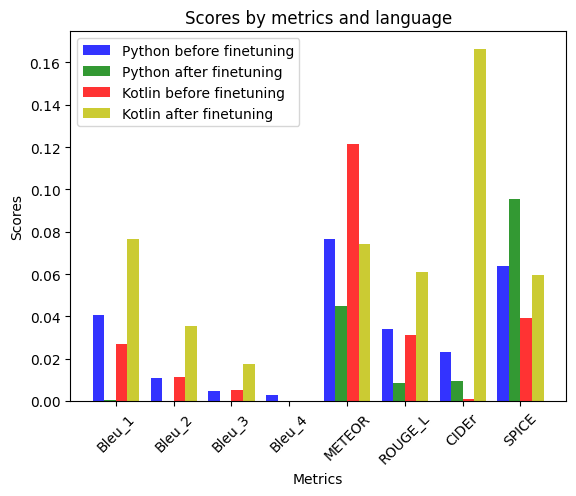

In [12]:
import matplotlib.pyplot as plt

labels = list(python_before_finetuning.keys())
python_before = list(python_before_finetuning.values())
python_after = list(python_after_finetuning.values())
kotlin_before = list(kotlin_before_finetuning.values())
kotlin_after = list(kotlin_after_finetuning.values())

x = range(len(labels))

fig, ax = plt.subplots()

bar_width = 0.2
index = 0
opacity = 0.8


rects1 = ax.bar([i - 1.5 * bar_width for i in x], python_before, bar_width, alpha=opacity, color='b', label='Python before finetuning')
rects2 = ax.bar([i - 0.5 * bar_width for i in x], python_after, bar_width, alpha=opacity, color='g', label='Python after finetuning')
rects3 = ax.bar([i + 0.5 * bar_width for i in x], kotlin_before, bar_width, alpha=opacity, color='r', label='Kotlin before finetuning')
rects4 = ax.bar([i + 1.5 * bar_width for i in x], kotlin_after, bar_width, alpha=opacity, color='y', label='Kotlin after finetuning')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Scores by metrics and language')

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()

plt.show()